###Prepared by: Michael Akinosho
###Date: November 29th, 2021

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [44]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
filepath = '/content/drive/Othercomputers/My Laptop/sales_predictions/'
filename = 'sales_predictions.csv'
filepathname = filepath + filename

In [46]:
df = pd.read_csv(filepathname,header=0)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [47]:
df['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [49]:
print(df.isnull().sum())

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [50]:
print(df['Item_Fat_Content'].value_counts())
df.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat','reg':'Regular'}},inplace=True)
print('\n')
print(df['Item_Fat_Content'].value_counts())

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


In [51]:
#Creating the dataframes for X and y
y = df['Item_Outlet_Sales']
#X = df.drop(columns=['Item_Outlet_Sales'])
#The SimpleImputer is failing on the Item Weight and Outlet Size features, and
#Item Identifier does not appear help as it an index for the items sold
X = df.drop(columns=['Item_Outlet_Sales','Item_Weight','Outlet_Size','Item_Identifier'])

In [52]:
#Creating the Train Test Split
#Appears the random state of 42 is causing over-fitting
#Leaving this value based on instructions
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [53]:
#Making column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)

print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
categorical columns are ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type']


In [54]:
#Instantiating transformers
#median_imputer = SimpleImputer(strategy = 'mean',copy=False)
freq_imputer = SimpleImputer(strategy = 'most_frequent',copy=False)
#one_hot_encoder = OneHotEncoder(sparse = False, handle_unknown='error',drop='first')

mean_imputer = SimpleImputer(strategy = 'mean',copy=False)
one_hot_encoder = OneHotEncoder(sparse = False, handle_unknown='error',drop='first')

In [55]:
#Instantiate the scaler
scaler = StandardScaler()

In [56]:
#Matching transformers with columns
#impute median of numeric columns
mean_tuple = (mean_imputer, num_selector)

#impute scaler tuple
scaler_tuple = (scaler, num_selector)

#impute most frequent of categorical columns
freq_tuple = (freq_imputer, cat_selector)

#one-hot encode categorical columns
ohe_tuple = (one_hot_encoder, cat_selector)

In [57]:
column_transformer = make_column_transformer(mean_tuple,scaler_tuple,ohe_tuple)

In [58]:
#Dataframe to hold all the computed metrics for linear regression and regression tree, R2 and RMSE, and train and test
df_reg_metrics = pd.DataFrame(columns = ["Regression Model","Metric Type","Split Type","Score"])


In [59]:
#Function to perform regression calculations across 
def calculate_regression_metrics(reg_type, X_train, X_test, y_train, y_test):
    global x_predict_nparray
    #Access the same dictionary initialized outside of the function
    global df_reg_metrics
    #Provide access to the column transformer already created prior to the function
    global column_transformer
    #Since only two regression models are employed, Linear Regression and
    #Decision Tree, the if statement is simpler and linear regression is only
    #excuted through the return True statement

    if reg_type == "linear regression":
        used_reg = LinearRegression()

        pipe = make_pipeline(column_transformer, used_reg)
        pipe.fit(X_train, y_train)

        df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"R2",'Split Type':"Train",'Score':r2_score(y_train, pipe.predict(X_train))}, ignore_index = True)
        df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"R2",'Split Type':"Test",'Score':r2_score(y_test, pipe.predict(X_test))}, ignore_index = True)
        df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"RMSE",'Split Type':"Train",'Score':np.sqrt(mean_squared_error(y_train, pipe.predict(X_train)))}, ignore_index = True)
        df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"RMSE",'Split Type':"Test",'Score':np.sqrt(mean_squared_error(y_test, pipe.predict(X_test)))}, ignore_index = True)
        
        return True

    #Run the Decision Model to determine the depth
    used_reg = DecisionTreeRegressor(random_state = 42)
    pipe = make_pipeline(column_transformer, used_reg)
    pipe.fit(X_train, y_train)
    #print("Depth is: ",used_reg.get_depth()+1)
    #With max depth range known, next optimal level is determined within the
    #subsequent for loop
    max_depth_range = list(range(2,used_reg.get_depth()+1))
    score_list = []
    for depth in max_depth_range:
        used_reg = DecisionTreeRegressor(max_depth = depth, random_state = 42)
        pipe = make_pipeline(column_transformer, used_reg)
        pipe.fit(X_train, y_train)
        temp = r2_score(y_test, pipe.predict(X_test))
        score_list.append(temp)

    max_depth_level = score_list.index(max(score_list)) + 2
    #print("Max depth level is:", max_depth_level)
    used_reg = DecisionTreeRegressor(max_depth = max_depth_level, random_state = 42)
    pipe = make_pipeline(column_transformer, used_reg)
    pipe.fit(X_train, y_train)

    #Using optimal max depth, the decision tree model is run again to compute
    #the R2 score and Root Mean Squared Error
    df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"R2",'Split Type':"Train",'Score':r2_score(y_train, pipe.predict(X_train))}, ignore_index = True)
    df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"R2",'Split Type':"Test",'Score':r2_score(y_test, pipe.predict(X_test))}, ignore_index = True)
    df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"RMSE",'Split Type':"Train",'Score':np.sqrt(mean_squared_error(y_train, pipe.predict(X_train)))}, ignore_index = True)
    df_reg_metrics = df_reg_metrics.append({'Regression Model':reg_type,'Metric Type':"RMSE",'Split Type':"Test",'Score':np.sqrt(mean_squared_error(y_test, pipe.predict(X_test)))}, ignore_index = True)
        

In [60]:
#Task 1, calling function to perform linear regression to evaluate R2 score and RMSE
calculate_regression_metrics("linear regression",X_train, X_test, y_train, y_test)

#Task 2, calling function to decision tree regression to evaluate R2 score and RMSE
calculate_regression_metrics("regression tree",X_train, X_test, y_train, y_test)

In [61]:
df_reg_metrics

,Regression Model,Metric Type,Split Type,Score
0,linear regression,R2,Train,0.561491
1,linear regression,R2,Test,0.567253
2,linear regression,RMSE,Train,1139.186952
3,linear regression,RMSE,Test,1092.675298
4,regression tree,R2,Train,0.612058
5,regression tree,R2,Test,0.585698
6,regression tree,RMSE,Train,1071.493232
7,regression tree,RMSE,Test,1069.134651


Based on the scores, I have decided to implement the Regression Tree Model.
This is based on the RMSE train and test scores being within 0.22% of each other.
Also, the R2 score for the decision tree shows appropriate fitting no over-fitting observed.

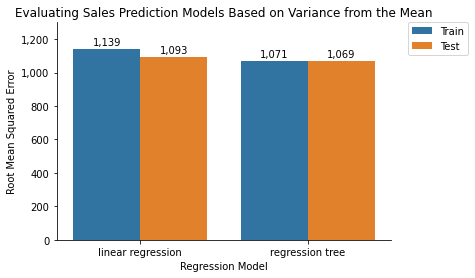

In [62]:
rmse_filter = df_reg_metrics['Metric Type'] == 'RMSE'
df_reg_metrics_RMSE = df_reg_metrics.loc[rmse_filter]
ax = sns.barplot(data=df_reg_metrics_RMSE,x='Regression Model',y='Score',hue='Split Type', ci=None);
ax.set(ylabel="Root Mean Squared Error")
ax.set(ylim=(0,1300))
y_ax_labels = ['{:,.0f}'.format(x) for x in ax.get_yticks()/1]
ax.set_yticklabels(y_ax_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Evaluating Sales Prediction Models Based on Variance from the Mean')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2.0, height_l*1.02, '{0:,.0f}'.format(height_l),ha='center' )
    ax.text(right.get_x() + right.get_width()/2.0, height_r*1.02, '{0:,.0f}'.format(height_r),ha='center' )

try:
    plt.savefig(filepath + "RMSE_RegressionModels.svg", format="svg",bbox_inches='tight')
except FileNotFoundError:
    print('Unable to save, folder not found')
    pass
else:
    plt.show()

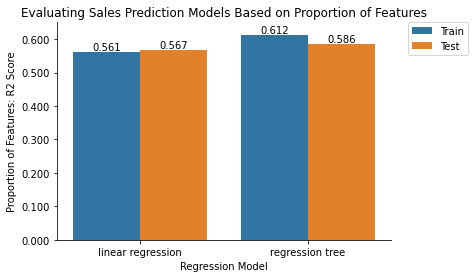

In [63]:
r2_filter = df_reg_metrics['Metric Type'] == 'R2'
df_reg_metrics_R2 = df_reg_metrics.loc[r2_filter]
ax = sns.barplot(data=df_reg_metrics_R2,x='Regression Model',y='Score',hue='Split Type', ci=None);
ax.set(ylabel="Proportion of Features: R2 Score")
ax.set(ylim=(0,0.65))
y_ax_labels = ['{:,.3f}'.format(x) for x in ax.get_yticks()/1]
ax.set_yticklabels(y_ax_labels)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Evaluating Sales Prediction Models Based on Proportion of Features')
ax.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)

bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2.0, height_l*1.01  , '{0:,.3f}'.format(height_l),ha='center' )
    ax.text(right.get_x() + right.get_width()/2.0, height_r*1.01, '{0:,.3f}'.format(height_r),ha='center' )

try:
    plt.savefig(filepath + "R2_Score_RegressionModel.svg", format="svg",bbox_inches='tight')
except FileNotFoundError:
    print('Unable to save, folder not found')
    pass
else:
    plt.show()